In [21]:
from typing import List, Tuple
from footballdashboardsdata.datasource import DataSource
from dbconnect.connector import Connection
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler


COMPUTED_STATS = [
    ('aerial_pct','Header Win Pct', 'SUM(aerials_won)/(SUM(aerials_won)+SUM(aerials_lost))', False),
    ('tackles_won_pct', 'Tackle Win Pct', 'SUM(tackles_won)/SUM(tackles)', False),
    ('def_ground_duels_won_pct', 'Defensive Ground Duel Win Pct', 'SUM(tackles_vs_dribbles_won)/SUM(tackles_vs_dribbles)', False),
]
def add_years(original_date, years):
    try:
        # Calculate the target year
        target_year = original_date.year + years
        
        # Try to create a new date with the target year
        new_date = original_date.replace(year=target_year)
    except ValueError:
        # Handle cases where the new date is invalid (e.g., February 29th on a non-leap year)
        new_date = original_date + (dt.date(target_year, 3, 1) - dt.date(original_date.year, 3, 1))
    
    return new_date

class ScatterDataSource(DataSource):

    COL_RENAME_DICT = {
        'enriched_position':'Position',
        'xag': 'xAG',
        'npxg':'NPxG',
        'xa':'xA',
        'npxg_xa':'NPxG+xA',
        'xg':'xG',
        'comp':'League',
        'squad':'Team'
    }

    MOST_COMMON_AGG_COLS = ['enriched_position']
    CATEGORICAL_COLS = ['comp','team']

    @classmethod
    def get_name(cls):
        return "ScatterDataSource"
    
    def _format_label(self, label:str, normalize_per_90)->str:
        try:
            label_n = next(t[1] for t in COMPUTED_STATS if t[0] == label)
        except:
            if label in self.COL_RENAME_DICT:
                label_n=  self.COL_RENAME_DICT[label]
            else:
                label_n =  label.replace("_", " ").title()        
        if (
            normalize_per_90 and label != 'minutes' and label not in self.CATEGORICAL_COLS and label not in self.MOST_COMMON_AGG_COLS and
            label not in [v[0] for v in COMPUTED_STATS if v[3]==False]
        ):
            label_n += " per 90"
        return label_n

    def _construct_player_query_string(self,
        leagues:List[str],
        season:int,
        teams:List[str],
        x_axis:str,
        y_axis:str,
        size_axis:str,
        color_axis:str,
        position_filter:List[str],
        dob_values_filter:Tuple[int,int]
        
    

    )->str:
        try:
            x_axis = next(t[2] for t in COMPUTED_STATS if t[0] == x_axis)
        except:
            x_axis = f"SUM({x_axis})"
        try:
            y_axis = next(t[2] for t in COMPUTED_STATS if t[0] == y_axis)
        except:
            y_axis = f"SUM({y_axis})"

        league_string = ", ".join([f"'{league}'" for league in leagues])
        query_string = f"""
        SELECT player_id, player, comp, squad,season,
        SUM(minutes) AS minutes,
        {x_axis} AS x_axis,
        {y_axis} AS y_axis
        """
        if size_axis:
            query_string += f",SUM({size_axis}) AS size_axis"
        if color_axis: 
            if color_axis not in self.MOST_COMMON_AGG_COLS:
                if color_axis in self.CATEGORICAL_COLS:
                    query_string += f",{color_axis} AS color_axis"
                else:
                    query_string += f",SUM({color_axis}) AS color_axis"
        query_string += f"""
        FROM fbref AS t1
        WHERE season = {season}
        AND dob BETWEEN '{dob_values_filter[0]}' AND '{dob_values_filter[1]}'
        AND comp IN ({league_string})
        """
        if position_filter:
            position_string = ", ".join([f"'{position}'" for position in position_filter])
            query_string += f"AND enriched_position IN ({position_string})"
        if teams: 
            team_string = ", ".join([f"'{team}'" for team in teams])
            query_string += f"AND team IN ({team_string})"
        query_string += """
        GROUP BY player_id, player, comp, squad
        """
        
       
        if color_axis and color_axis in self.MOST_COMMON_AGG_COLS:
            orig_query_string = query_string
            query_string = f"""
                SELECT T1.player_id, T1.season, T1.player, T1.comp, T1.squad, T1.minutes, T1.x_axis, T1.y_axis, 
            """
            if size_axis:
                query_string+=f"T1.size_axis, "
            query_string+=f"""T2.{color_axis} AS color_axis
                FROM ({orig_query_string}) AS T1
                JOIN (
                    WITH RankedCatgroups AS (
                        SELECT 
                            player_id,
                            player,
                            squad,
                            comp,
                    
                            {color_axis},
                            ROW_NUMBER() OVER (PARTITION BY player_id, player,squad, comp ORDER BY COUNT(*) DESC) AS rn
                        FROM fbref
                        WHERE season={season}
                        AND dob BETWEEN '{dob_values_filter[0]}' AND '{dob_values_filter[1]}'
                        AND comp in ({league_string})
                """
            if teams:
                query_string += f"AND team IN ({team_string})"
            if position_filter:
                query_string += f"AND enriched_position IN ({position_string})"
            
            query_string += f"""
                    GROUP BY player_id, player, squad, comp, {color_axis}
                )
                SELECT 
                    player_id,
                    player,
                    squad,
                    comp,
                    {color_axis}
                FROM RankedCatgroups
                WHERE rn = 1
                )  T2
                ON T1.player_id = T2.player_id
                AND T1.player = T2.player
                AND T1.squad = T2.squad
                AND T1.comp = T2.comp
            """
        print(query_string)
        return query_string
        
        

    
    def impl_get_data(self, 
        leagues:List[str],
        season:int,
        team_aggregation:bool,
        x_axis:str,
        y_axis:str,
        
        teams:List[str]=None,
        item_highlights:List[str]=None,
        team_highlights:List[str]=None,
        size_axis:str=None,
        color_axis:str=None,
        position_filter:List[str]=None,
        minutes_filter:int=0,
        normalize_per_90:bool=True,
        age_filter:Tuple[int,int]=None,
        
    ):
        item_highlights = item_highlights or []
        team_highlights = team_highlights or []
        age_filter = age_filter or (0,100)
        dob_values = (add_years(dt.datetime.now(), -age_filter[1]).strftime('%Y-%m-%d'), add_years(dt.datetime.now(), -age_filter[0]).strftime('%Y-%m-%d'))
        if not team_aggregation:
            data = self._get_player_data(
                leagues=leagues,
                season=season,
                teams=teams,
                x_axis=x_axis,
                y_axis=y_axis,
                size_axis=size_axis,
                color_axis=color_axis,
                position_filter=position_filter,
                minutes_filter=minutes_filter,
                normalize_per_90=normalize_per_90,
                dob_values_filter=dob_values
            )
        
        if not team_aggregation:
            data['annotate']= data['player'].apply(lambda x: x in item_highlights) 
            data['annotate'] = data['annotate'] | data['squad'].apply(lambda x: x in team_highlights)
        else:
            data['annotate']= data['squad'].apply(lambda x: x in item_highlights)

        data['x_axis_name'] = self._format_label(x_axis,normalize_per_90)
        data['y_axis_name'] = self._format_label(y_axis, normalize_per_90)
        if size_axis:
            data['size_axis_name'] = self._format_label(size_axis, normalize_per_90)
        if color_axis:
            data['color_axis_name'] = self._format_label(color_axis, normalize_per_90)
        return data.dropna()


    def _fix_types(self, data:pd.DataFrame, color_axis:str)->pd.DataFrame:
        data['x_axis']=data['x_axis'].astype(float)
        data['y_axis']=data['y_axis'].astype(float)
        data['minutes']=data['minutes'].astype(float)
        if 'size_axis' in data.columns:
            data['size_axis']=data['size_axis'].astype(float)
        if 'color_axis' in data.columns and (color_axis not in self.CATEGORICAL_COLS and color_axis not in self.MOST_COMMON_AGG_COLS):
            data['color_axis']=data['color_axis'].astype(float)
        return data

    def _get_player_data(
            self,
            leagues:List[str],
            season:int,
            teams:List[str],
            x_axis:str,
            y_axis:str,
            size_axis:str,
            color_axis:str,
            position_filter:List[str],
            normalize_per_90:bool,
            minutes_filter:int,
            dob_values_filter:Tuple[int,int],
            )->pd.DataFrame:
    
        


        
        query_string = self._construct_player_query_string(
            leagues=leagues, 
            season=season,
            
            teams=teams,
            x_axis=x_axis,
            y_axis=y_axis,
            size_axis=size_axis,
            color_axis=color_axis,
            position_filter=position_filter,
            dob_values_filter=dob_values_filter
        )
        raw_data = Connection('M0neyMa$e').query(query_string)
        #raw_data = self._fix_types(raw_data, color_axis)
        raw_data = raw_data[raw_data['minutes'] > minutes_filter]
        
        
        if normalize_per_90:
            if x_axis != 'minutes' and x_axis not in [v[0] for v in COMPUTED_STATS if v[3]==False]:
                raw_data["x_axis"] = raw_data["x_axis"] / raw_data['minutes'] * 90
            if y_axis != 'minutes' and y_axis not in [v[0] for v in COMPUTED_STATS if v[3]==False]:
                raw_data["y_axis"] = raw_data["y_axis"] / raw_data['minutes'] * 90
            if size_axis and size_axis != 'minutes':
                raw_data["size_axis"] = raw_data["size_axis"] / raw_data['minutes'] * 90
            if color_axis and color_axis != 'minutes' and (color_axis not in self.CATEGORICAL_COLS and color_axis not in self.MOST_COMMON_AGG_COLS):
                raw_data["color_axis"] = raw_data["color_axis"] / raw_data['minutes'] * 90
        return raw_data
        

In [27]:
dt.date.today() - dt.timedelta(days=365*25)

datetime.date(1999, 6, 9)

In [9]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import register_cmap
ListedColormap(['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'], 'cb_friendly')
register_cmap('cb_friendly', cmap=ListedColormap(['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']))

In [62]:
from typing import Dict, Tuple
import numpy as np
from pandas import DataFrame
from footballdashboards._types._custom_types import PlotReturnType
from footballdashboards.dashboard.dashboard import Dashboard
from footballdashboards._types._dashboard_fields import FigSizeField, ColorMapField, ColorField
from footballdashboards.helpers.mclachbot_helpers import  get_ball_logo2
from footballdashboards.helpers.matplotlib import  get_aspect
from matplotlib.figure import Figure
from matplotlib.patches import Rectangle
from matplotlib.axes import Axes
import cmasher as cmr
from adjustText import adjust_text
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from footballdashboards.helpers.fonts import font_normal, font_bold, font_italic, font_varsity, font_berpatroli, font_europa, font_royal_crescent
from footballdashboards.helpers.formatters import  smartest_name_formatter_yet
class ScatterDashboard(Dashboard):
    figsize = FigSizeField("figsize", default=(10, 10))
    title = ""
    color_map = ColorMapField("color_map", default='viridis')
    categorical_color_map = ColorMapField("categorical_color_map", default='Dark2')
    default_color = ColorField("default_color", default='blue')
    min_size = 10
    max_size = 100
    default_size = 50
    means = False
    std_devs = False

    def _required_data_columns(self) -> Dict[str, str]:
        return {}
    @property
    def datasource_name(self) -> str:
        return "ScatterDataSource"
    
    def _setup_figure(self, data:pd.DataFrame) -> Tuple[Figure, Dict[str, Axes]]:
        if 'size_axis' in data.columns or ('color_axis' in data.columns and data['color_axis'].dtype == 'O'):
            mosaic_layout = [["header"],["scatter"],["footer"]]
            height_ratios = [0.075, 0.85, 0.075]
        else:
            mosaic_layout = [["header"],["scatter"]]
            height_ratios = [0.075, 0.925]
        fig = Figure(figsize=self.figsize, tight_layout=True, constrained_layout=True, facecolor=self.facecolor)
    
        axes = fig.subplot_mosaic(mosaic_layout, gridspec_kw={'height_ratios': height_ratios, })
        for ax in axes.values():
            if ax != axes['scatter']:
                ax.axis('off')
            if ax == axes['scatter']:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)

        return fig, axes

    def _league_str(self, league_list):
        league_str = ''
        if set(['Premier League','La Liga', 'Serie A','Bundesliga','Ligue 1']) - set(league_list) == set():
            league_str = "Top 5 Leagues"
            league_list = list(set(league_list) - set(['Premier League','La Liga', 'Serie A','Bundesliga','Ligue 1']))
        if len(league_list) == 0:
            return league_str
        if len(league_list) > 3:
            if league_str:
                league_str += ', '
            league_str += ', '.join (league_list[:3]) + ' and ' + str(len(league_list) - 3) + ' more'
        else:
            if league_str:
                league_str += ', '
            league_str += ', '.join(league_list)
        #replace the last comma with an and
        league_str = league_str.rsplit(', ', 1)
        if len(league_str) > 1:
            league_str = ' and '.join(league_str)
        else:
            league_str = league_str[0]
        return league_str
        

    def _draw_title(self, data: DataFrame, ax: Axes):
        if self.title: 
            title_text = self.title
        else:
            x_axis_name = self._format_label(data['x_axis_name'].iloc[0])
            y_axis_name = self._format_label(data['y_axis_name'].iloc[0])
            title_text = f"{x_axis_name} vs {y_axis_name}"
        ax.text(0.0, 0.95, title_text, fontsize=20, ha='left', va='top', fontproperties=font_europa.prop)
        leagues_str = self._league_str(data['comp'].unique())
        second_line_str = leagues_str
        second_line_str +=" | "
        second_line_str += f"Season {data['season'].iloc[0]}"
        ax.text(0.0, 0.5, second_line_str, fontsize=12, ha='left', va='top', fontproperties=font_normal.prop)

    def _size(self, data: DataFrame) -> DataFrame:
        if 'size_axis' in data.columns:
            scaler = MinMaxScaler(feature_range=(self.min_size, self.max_size))
            return scaler.fit_transform(data[['size_axis']])
        else:
            return np.full(data.shape[0], self.default_size)
    
    def _format_label(self, label:str)->str:
       return label
    def _colors(self, data: DataFrame) -> str:
        if 'color_axis' in data.columns:
            if data['color_axis'].dtype == 'O': # categorical
                colormap_name = self.categorical_color_map
                cmap = cmr.get_sub_cmap(colormap_name, 0, 1)
                return cmap(data['color_axis'].astype('category').cat.codes)
            else:
                scaler = MinMaxScaler()
                colormap_name = self.color_map
                cmap = cmr.get_sub_cmap(colormap_name, 0, 1)
                return cmap(scaler.fit_transform(data[['color_axis']]))
        else:
            return self.default_color

    def _draw_colorbar(self, fig: Figure, ax: Axes, scatter, color_axis_name, color_axis):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.50)
        cbar = fig.colorbar(scatter, cax=cax, orientation='vertical', aspect=100)
        cbar.set_label(color_axis_name)
        cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar.set_ticklabels([f'{color_axis.min():.2f}', f'{color_axis.quantile(0.2):.2f}', f'{color_axis.quantile(0.4):.2f}', f'{color_axis.quantile(0.6):.2f}', f'{color_axis.quantile(0.8):.2f}', f'{color_axis.max():.2f}'], fontproperties=font_normal.prop)
        #cbar.ax.yaxis.set_label_position('bottom')
        cbar.ax.yaxis.set_ticks_position('left')
    
    def _annotate(self, data: DataFrame, ax: Axes, scatter):
        annotated = data[data['annotate']].copy()
        if 'player' in annotated.columns:
            annotated_column = 'player'
            annotated[annotated_column] = annotated[annotated_column].apply(smartest_name_formatter_yet)
        else:
            annotated_column = 'squad'
        texts = []
        props = dict(boxstyle="round", facecolor=self.facecolor, alpha=1)
        for _, row in annotated.iterrows():
            texts.append(
                ax.text(
                    row['x_axis'],
                    row['y_axis'],
                    row[annotated_column],
                    ha='left',
                    va='bottom',
                    size=11,
                    fontproperties=font_normal.prop,
                    #bbox=props,
                    zorder=30,
                )
            )
        adjust_text(
            texts,
            ax=ax,
            objects=scatter,
            only_move={"text": "xy"},
            #force_text=(5,5),
            #force_static=(5,5),
            #force_explode=(0.2,1),
            ensure_inside_axes=True,
            avoid_self=True,
            arrowprops=dict(arrowstyle="simple", color='black', lw=1),
            zorder=30,
        )

    def _draw_scatter(self, data: DataFrame, ax: Axes, fig:Figure, footer_ax:Axes):
        ax.set_facecolor(self.facecolor)
        x_axis_name = data['x_axis_name'].iloc[0]
        y_axis_name = data['y_axis_name'].iloc[0]
        if 'size_axis_name' in data.columns:
            size_axis_name = data['size_axis_name'].iloc[0]
        else:
            size_axis_name = None
        if 'color_axis_name' in data.columns:
            color_axis_name = data['color_axis_name'].iloc[0]
        else:
            color_axis_name = None

        size = self._size(data)
        colors = self._colors(data)
        scatter= ax.scatter(data['x_axis'], data['y_axis'], s=size, c=colors, alpha=0.8, zorder=20)
        if self.means:
            ax.axvline(data['x_axis'].mean(), color='darkgreen', linestyle='dashed', linewidth=1, zorder=2)
            ax.axhline(data['y_axis'].mean(), color='darkgreen', linestyle='dashed', linewidth=1, zorder=2)

        if self.std_devs:
            #draw std devs as a filled square area
            x_mean = data['x_axis'].mean()
            y_mean = data['y_axis'].mean()
            x_std = data['x_axis'].std()
            y_std = data['y_axis'].std()
            ax.add_patch(Rectangle((x_mean - x_std, y_mean - y_std), 2 * x_std, 2 * y_std, fill=True, color='green', alpha=0.1, zorder=3))
        ax.grid(True, alpha=0.4, zorder=1, linestyle='dotted')
        ax.set_xlabel(self._format_label(x_axis_name))
        ax.set_ylabel(self._format_label(y_axis_name))
        plotted_color_legend=False

        legend_kwargs = dict(
            title_fontsize=8,
            fontsize=8,
            frameon=False,
            bbox_to_anchor=(0, 0, 1, 1),
            
            prop=font_normal.prop,
            columnspacing=0.5
        )

        if 'color_axis' in data.columns:
            if data['color_axis'].dtype == 'O': # categorical
                # draw legend in the footer
                #footer_ax.axis('off')
                plotted_color_legend=True
                legend_elements = [Rectangle((0, 0), 1, 1, color=cmr.get_sub_cmap(self.categorical_color_map, 0, 1)(i), label=cat) for i, cat in enumerate(data['color_axis'].astype("category").cat.categories)]
                legend = footer_ax.legend(
                    handles=legend_elements, 
                    title=self._format_label(color_axis_name),
                     loc='upper left', 
                     ncols = int(np.ceil(len(legend_elements)/2)), 
                        **legend_kwargs
                )
                if "size_axis" in data.columns:
                    footer_ax.add_artist(legend)

            else:
                self._draw_colorbar(fig, ax, scatter, self._format_label(color_axis_name), data['color_axis'])
        if "size_axis" in data.columns:
            #draw legend in the footer
            #footer_ax.axis('off')
            #sizes = [self.min_size, (self.min_size + self.max_size) / 2, self.max_size]
            min_value = data['size_axis'].min()
            max_value = data['size_axis'].max()
            location = 'upper left' if not plotted_color_legend else 'upper right'
            interp = interp1d( [self.min_size, self.max_size], [min_value, max_value],fill_value='extrapolate' )
            handles, labels = scatter.legend_elements("sizes", num = 5, func=lambda x: interp(x))
            #map sizes to values
            
            #sizes = interp(labels)
            legend = footer_ax.legend(
                handles, 
                labels, 
                title=self._format_label(size_axis_name),
                ncols = int(np.ceil(len(handles)/2)), 
                loc=location, 
                **legend_kwargs
            )
            


        self._annotate(data, ax, scatter)
        left_bottom, right_top = ax.get_position() * ax.figure.get_size_inches()
        width, height = right_top - left_bottom
        aspect =  height/ width
        
        logo_size = 0.2
        logo_inset_ax = ax.inset_axes([1-logo_size*aspect, 0.0, aspect*logo_size, logo_size], alpha=0.3, zorder=0.1)
        logo_inset_ax.imshow(get_ball_logo2(), alpha=0.5)
        logo_inset_ax.axis('off')
        ax.text(0.01, 0.0, "Data by: www.fbref.com", fontsize=8, ha='left', va='bottom', transform=ax.transAxes, zorder=100, alpha=0.5, fontproperties=font_normal.prop)


        
    def _plot_data(self, data: DataFrame) -> Tuple[Figure, Dict[str, Axes]]:
        fig, axes = self._setup_figure(data)
        self._draw_title(data, axes['header'])
        self._draw_scatter(data, axes['scatter'],fig, axes['footer'] if 'footer' in axes else None)
        #self._draw_footer(data, axes['logo'])
        return fig, axes

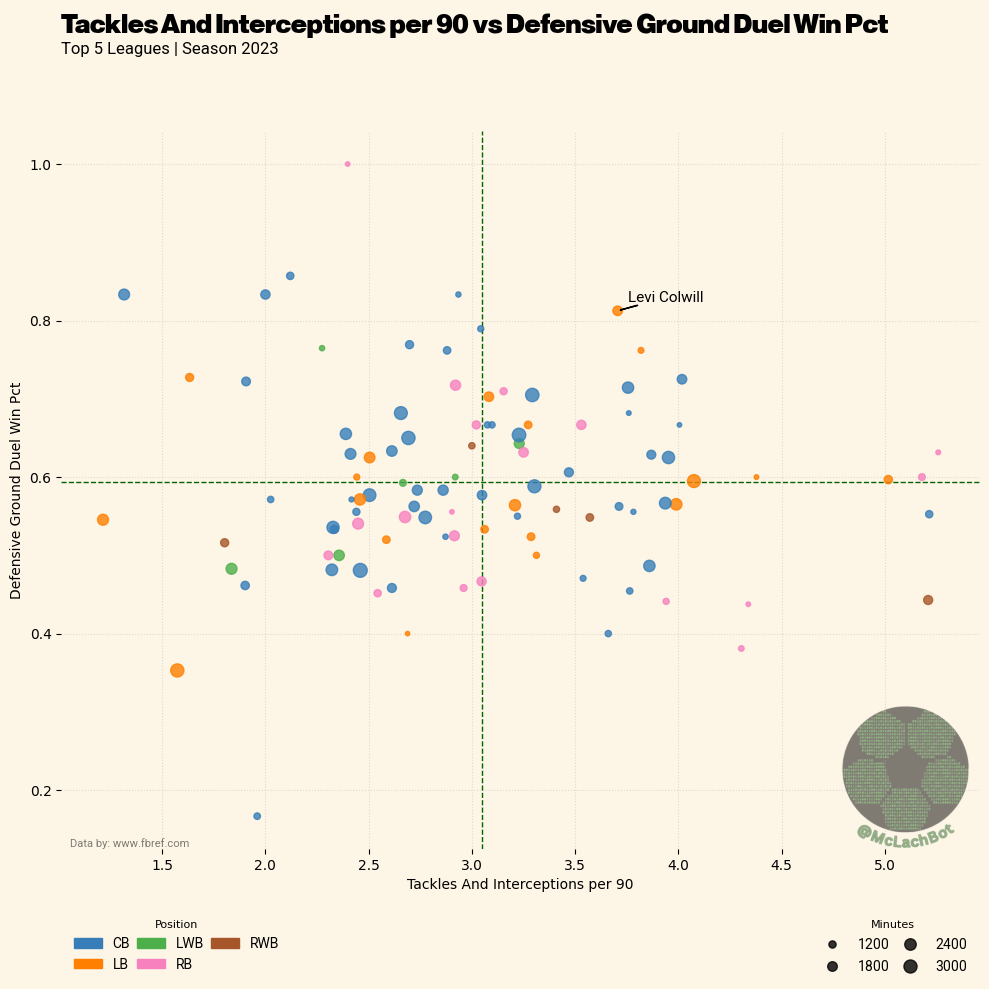

In [63]:
from footballdashboardsdata.datasource import DataSource
%matplotlib inline
dash = ScatterDashboard(DataSource)
#dash.title="Michael Olise's elite season"
dash.categorical_color_map='cb_friendly'
dash.means=True
#dash.std_devs=True
fig, axes = dash.plot_dataframe(data_df)
#cbar = fig.colorbar(axes['scatter'].collections[0], ax=axes['scatter'])
fig

In [372]:
fig.savefig('scatter.png', dpi=300, bbox_inches='tight')

In [22]:
data = ScatterDataSource()

In [24]:
data_df = data.impl_get_data(
    season=2023, leagues=['Premier League','La Liga', 'Serie A','Bundesliga','Ligue 1'], 
    team_aggregation=False, age_filter=(0, 23),
    x_axis='tackles_and_interceptions', y_axis='def_ground_duels_won_pct', size_axis='minutes', color_axis='enriched_position', position_filter=['CB','LB','RB','LWB','RWB'], minutes_filter=700, 
    item_highlights=['levi colwill']
)


                SELECT T1.player_id, T1.season, T1.player, T1.comp, T1.squad, T1.minutes, T1.x_axis, T1.y_axis, 
            T1.size_axis, T2.enriched_position AS color_axis
                FROM (
        SELECT player_id, player, comp, squad,season,
        SUM(minutes) AS minutes,
        SUM(tackles_and_interceptions) AS x_axis,
        SUM(tackles_vs_dribbles_won)/SUM(tackles_vs_dribbles) AS y_axis
        ,SUM(minutes) AS size_axis
        FROM fbref AS t1
        WHERE season = 2023
        AND dob BETWEEN '2001-06-02' AND '2024-06-02'
        AND comp IN ('Premier League', 'La Liga', 'Serie A', 'Bundesliga', 'Ligue 1')
        AND enriched_position IN ('CB', 'LB', 'RB', 'LWB', 'RWB')
        GROUP BY player_id, player, comp, squad
        ) AS T1
                JOIN (
                    WITH RankedCatgroups AS (
                        SELECT 
                            player_id,
                            player,
                            squad,
                        

In [28]:
data_df['comp'].unique()

array(['Premier League', 'La Liga', 'Bundesliga', 'Serie A', 'Ligue 1'],
      dtype=object)

In [5]:
data_df.sort_values('x_axis', ascending=False).head(25)

,player_id,season,player,comp,squad,minutes,x_axis,y_axis,size_axis,color_axis,annotate,x_axis_name,y_axis_name,size_axis_name,color_axis_name
221,bbd67769,2023,conor bradley,Premier League,liverpool,753.0,5.258964,0.6667,753.0,RB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
73,dfc5d4fa,2023,soungoutou magassa,Ligue 1,monaco,1208.0,5.215232,0.5789,1208.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
72,ee45fd85,2023,vanderson,Ligue 1,monaco,1641.0,5.210238,0.3333,1641.0,RWB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
115,cc6de655,2023,juanlu sanchez,La Liga,sevilla,1112.0,5.179856,0.4815,1112.0,RB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
189,7ebd0896,2023,max finkgrafe,Bundesliga,koln,1453.0,5.017206,0.4878,1453.0,LB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
161,da011f18,2023,lewis hall,Premier League,newcastle_utd,740.0,4.378378,0.5000,740.0,LB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
125,2dce876a,2023,carmona,La Liga,getafe,726.0,4.338843,0.5000,726.0,RB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
83,c385bf49,2023,sael kumbedi,Ligue 1,lyon,878.0,4.305239,0.2000,878.0,RB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
69,40221fa7,2023,bradley locko,Ligue 1,brest,2959.0,4.075701,0.5439,2959.0,LB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
81,29c91632,2023,abakar sylla,Ligue 1,strasbourg,1792.0,4.017857,0.6154,1792.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position


In [157]:
data_df['color_axis'].astype('category').cat.categories[0]

'AM'

In [12]:
data_df

,player_id,season,player,comp,squad,minutes,x_axis,y_axis,size_axis,color_axis,annotate,x_axis_name,y_axis_name,size_axis_name,color_axis_name
0,93e08bce,2023,ameen al dakhil,Premier League,burnley,1056.0,1.960227,0.4118,1056.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
2,5ad50391,2023,josko gvardiol,Premier League,manchester_city,2328.0,3.208763,0.5818,2328.0,LB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
4,230f0471,2023,nathan patterson,Premier League,everton,982.0,3.940937,0.4375,982.0,RB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
5,0ad53bdc,2023,milos kerkez,Premier League,bournemouth,1781.0,3.082538,0.3958,1781.0,LB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
6,88968486,2023,illia zabarnyi,Premier League,bournemouth,3330.0,2.459459,0.5530,3330.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,b8aedf06,2023,lucas beraldo,Ligue 1,paris_s_g,1008.0,3.660714,0.5161,1008.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
234,1a066e69,2023,maxime esteve,Premier League,burnley,1309.0,3.712758,0.5208,1309.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
237,c55de1f5,2023,nathaniel adjei,Ligue 1,lorient,1231.0,2.120227,0.5833,1231.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position
238,cf1ef7ec,2023,chrislain matsima,Ligue 1,clermont_foot,1180.0,2.440678,0.6286,1180.0,CB,False,Tackles And Interceptions per 90,Aerial Pct per 90,Minutes,Position


In [56]:
def _league_str(league_list):
    league_str = ''
    if set(['Premier League','La Liga', 'Serie A','Bundesliga','Ligue 1']) - set(league_list) == set():
        league_str = "Top 5 Leagues"
        league_list = list(set(league_list) - set(['Premier League','La Liga', 'Serie A','Bundesliga','Ligue 1']))
    if len(league_list) == 0:
        return league_str
    if len(league_list) > 3:
        if league_str:
            league_str += ', '
        league_str += ', '.join (league_list[:3]) + ' and ' + str(len(league_list) - 3) + ' more'
    else:
        if league_str:
            league_str += ', '
        league_str += ', '.join(league_list)
    #replace the last comma with an and
    league_str = league_str.rsplit(', ', 1)
    if len(league_str) > 1:
        league_str = ' and '.join(league_str)
    else:
        league_str = league_str[0]
    return league_str
        

In [57]:
_league_str(['Premier League','La Liga', 'Bundesliga','Ligue 1', 'Serie A'])

'Top 5 Leagues'